# Improving the convergence of the self-consistent iterations via Aitken's delta-squared process

In [1]:
import numpy as np
import numpy.ma as ma
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1927)

In [3]:
# get random core hamiltonian
h1e = np.random.rand(6, 6) + 1j * np.random.rand(6, 6)
h1e += h1e.conj().T

beta = 3

# select chemical potential
energies = linalg.eigvalsh(h1e)

mu = 0.3 * (energies.min() + energies.max())

In [4]:
def FermiDirac(E):
    return 1 / (1 + np.exp(beta * (E - mu)))

In [5]:
# get the FD for the core hamiltonian
rho_initial = linalg.funm(h1e, FermiDirac)

In [6]:
def do_self_consistent(rho, cc, niter=30):
    """
    rho - initial density matrix
    cc - coupling constant 
    """
    #print(linalg.norm(rho))
    #norm = [linalg.norm(rho)]
    norm_diff = []
    
    for _ in range(niter):
    
        previous_rho = rho.copy()
    
        
        # Hamiltonian with self-consistent corrections 
        h = h1e + cc * rho ** 2
        rho = linalg.funm(h, FermiDirac)
        
        norm_diff.append(linalg.norm(rho - previous_rho))
    
    plt.title("$\||\\rho_{current} - \\rho_{previous}\||$ as we iterate")
    plt.semilogy(norm_diff)
    plt.xlabel("iteration")
    plt.ylabel('$\||\\rho_{current} - \\rho_{previous}\||$')
    plt.show()
    
    
    return rho

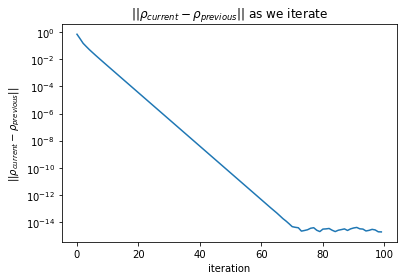

In [7]:
# note that if the coupling constant is low there is no problem
rho = do_self_consistent(rho_initial, 2, niter=100)

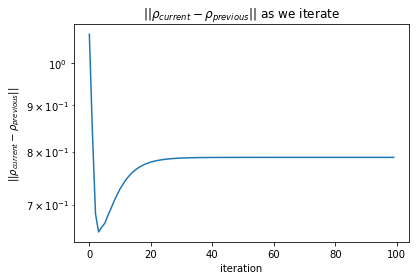

In [8]:
# if the coupling constant is high, we have a problem
rho = do_self_consistent(rho_initial, 4, niter=100)

# Solution: Let use [Aitken's $\Delta^2$-process](https://en.wikipedia.org/wiki/Aitken%27s_delta-squared_process) to improve the convergence 

In [9]:
def do_self_consistent_Aitken(rho, cc, niter=50):
    
    def single_iteration(rho_):
        h = h1e + cc * rho_ ** 2
        return linalg.funm(h, FermiDirac)
    
    norm_diff = []
    
    rho_0 = rho.copy()
    
    for _ in range(niter):
        previous_aitken_rho = rho_0.copy()
        
        rho_1 = single_iteration(rho_0)
        rho_2 = single_iteration(rho_1)
        
        # use masked arrays to track entries which converged
        aitken_rho = rho_2 - (rho_2 - rho_1) ** 2 / ma.array(rho_2 + rho_0 - 2 * rho_1)
        
        aitken_rho = ma.filled(aitken_rho, fill_value=rho_2)
        
        rho_0 = aitken_rho
        
        norm_diff.append(linalg.norm(aitken_rho - previous_aitken_rho))
        
        if np.allclose(aitken_rho, previous_aitken_rho):
            print("Iterations converged!!!")
            break
        
    plt.title("$\||\\rho_{current} - \\rho_{previous}\||$ as we iterate")
    plt.semilogy(norm_diff)
    plt.xlabel("iteration")
    plt.ylabel('$\||\\rho_{current} - \\rho_{previous}\||$')
    plt.show()
    
    return aitken_rho

Iterations converged!!!


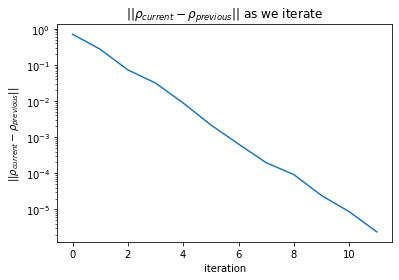

In [10]:
# this worked very well !!!!!
rho = do_self_consistent_Aitken(rho_initial, 4, niter=100)